In [46]:
import pandas as pd;
from spacy.tokenizer import Tokenizer
import en_core_web_lg
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

In [6]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
ss = pd.read_csv("data/sample_submission.csv")

In [20]:
print(train.columns.tolist())

['id', 'description', 'ratingCategory']


## resample

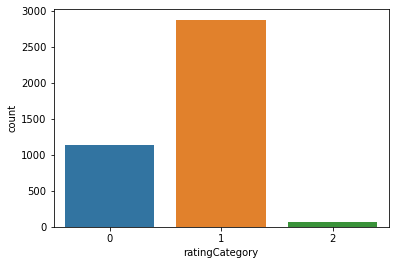

In [59]:
from seaborn import countplot
countplot(train.ratingCategory);

In [60]:
from sklearn.utils import resample

minority = train[train['ratingCategory'] == 0]
majority = train[train['ratingCategory'] == 1]
df_minority_upsampled = resample(minority,
                                 replace=True,
                                 n_samples=majority.shape[0]
                                )
train_upsampled = pd.concat([majority, df_minority_upsampled])

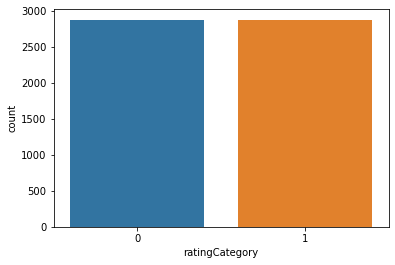

In [61]:
countplot(train_upsampled.ratingCategory);

## SpaCy vectorization

In [47]:
# spacy vectorization

nlp = en_core_web_lg.load()
def get_word_vectors(docs):
    return [nlp(doc).vector for doc in docs]

In [89]:
X_train = get_word_vectors(train['description'])
y_train = train.ratingCategory
X_test = get_word_vectors(test['description'])

## LSI /tfidf

In [114]:
X_train = train['description']
y_train = train.ratingCategory
X_test = test['description']

In [115]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=100, # Just here for demo. 
                   algorithm='randomized',
                   n_iter=10)

In [116]:
vect = TfidfVectorizer(stop_words='english',ngram_range=[1,3],min_df=5,max_df=0.97)
rfc = RandomForestClassifier()

## Pipeline /randomizedcvsearch

In [117]:
# tfidf -> svd (LSI PIPELINE)
lsi = Pipeline([('vect', vect), ('svd', svd)])

# lsi/xgbooster Pipe
#pipe = Pipeline([('svd',svd), ('clf', rfc)])
pipe = Pipeline([('lsi',lsi), ('clf', rfc)])

In [118]:
params = { 
    'lsi__svd__n_components': [50,100,150,200],
    'lsi__svd__n_iter': [5,10,15,20],
    'clf__n_estimators':[10,20,25,35],
    'clf__max_depth': [5,10,15,25,35]
}

In [119]:
rand_search = RandomizedSearchCV(pipe,param_distributions=params,cv=20,verbose=1,n_jobs=-1)
rand_search.fit(X_train,y_train)

Fitting 20 folds for each of 10 candidates, totalling 200 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  3.8min finished


RandomizedSearchCV(cv=20, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('lsi',
                                              Pipeline(memory=None,
                                                       steps=[('vect',
                                                               TfidfVectorizer(analyzer='word',
                                                                               binary=False,
                                                                               decode_error='strict',
                                                                               dtype=<class 'numpy.float64'>,
                                                                               encoding='utf-8',
                                                                               input='content',
                                                                               lowercase=True,
                         

## best model/pipe

In [120]:
rand_search.best_estimator_

Pipeline(memory=None,
         steps=[('lsi',
                 Pipeline(memory=None,
                          steps=[('vect',
                                  TfidfVectorizer(analyzer='word', binary=False,
                                                  decode_error='strict',
                                                  dtype=<class 'numpy.float64'>,
                                                  encoding='utf-8',
                                                  input='content',
                                                  lowercase=True, max_df=0.97,
                                                  max_features=None, min_df=5,
                                                  ngram_range=[1, 3], norm='l2',
                                                  preprocessor=None,
                                                  smooth_idf=True,
                                                  stop_words='english',
                                                  strip_

In [121]:
rand_search.best_params_

{'lsi__svd__n_iter': 20,
 'lsi__svd__n_components': 50,
 'clf__n_estimators': 20,
 'clf__max_depth': 15}

In [122]:
rand_search.best_score_

0.7279268292682926

## Predictions/submissions

In [123]:
pred = rand_search.predict(X_test)

In [124]:
sub = pd.DataFrame(columns=['id','ratingCategory'])
sub['id']=test.id
sub['ratingCategory']=pred
sub.to_csv("submission9.csv",index=False)

# OLD

In [34]:
# first
pipe = Pipeline(
    [
        ('vect',vect),
        ('clf',rfc)
    ]
)
parameters = {
    "vect__max_df" : (0.75,1.00),
    "vect__min_df" : (.02,.05),
    "clf__n_estimators":(5,10,),
    "clf__max_depth":(15,20)
}
rand_search = RandomizedSearchCV(pipe,param_distributions=parameters,cv=5,verbose=1,n_jobs=-1)
rand_search.fit(x_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   40.9s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('vect',
                                              TfidfVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.float64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=0.97,
                                                              max_features=None,
                                                              min_df=5,
                                                       